# Load libraries and data

In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
# Display up to 100 rows of data
pd.options.display.min_rows = 100

data = pd.read_csv('../data/Merged_Df_Cleaned_Enhanced 2.csv')

data.head()

,Show,Season,Episode,Time,Episode Length,IMDB Rating,Emmy Nominations,Emmy Wins,Air Date,SD_div_mean_2,...,Network_HBO (US),Network_IFC,Network_NBC,Network_Paramount Network,Network_Showtime,Network_Starz,Network_The CW,Network_The WB,Network_USA Network,Cancelled
0,2 Broke Girls,1,1,9:30 PM,22,7.3,NaN,NaN,9/19/2011,9159.676336,...,0,0,0,0,0,0,0,0,0,1
1,2 Broke Girls,1,2,8:30 PM,22,7.1,NaN,NaN,9/26/2011,3451.804293,...,0,0,0,0,0,0,0,0,0,1
2,2 Broke Girls,1,3,8:30 PM,22,7.2,NaN,NaN,10/3/2011,3977.461758,...,0,0,0,0,0,0,0,0,0,1
3,2 Broke Girls,1,4,8:30 PM,22,7.3,NaN,NaN,10/10/2011,7097.733100,...,0,0,0,0,0,0,0,0,0,1
4,2 Broke Girls,1,6,8:30 PM,22,7.2,NaN,NaN,10/24/2011,5883.807213,...,0,0,0,0,0,0,0,0,0,1


In [293]:
# Add an average metric of emotional scores (one per act instead of three)
new_data = data.copy()

# Rename Time column so it is not averaged into Time_ emotional scores
new_data = new_data.rename(columns={'Time': 'emission_time'})

for col in new_data.columns.to_list()[9:136]:
    col_prefix = col[:-2]
    new_column_name = "avg_" + col_prefix
    if new_column_name not in new_data.columns.to_list():    
        cols_to_avg = [col for col in new_data.columns.to_list() if col_prefix in col]
        new_data[new_column_name] = new_data[cols_to_avg].mean(axis = 1)

In [295]:
# Display new columns
new_data.iloc[:,165:].head()

,avg_SD_div_mean,avg_SD_sum,avg_SD_scaled,avg_Anger,avg_Surprise,avg_Disgust,avg_Sadness,avg_Neutral,avg_Fear,avg_Joy,...,avg_Drives,avg_Affiliation,avg_Achieve,avg_Power,avg_Reward,avg_Risk,avg_Relativ,avg_Motion,avg_Space,avg_Time
0,6893.333312,20.302666,651.359304,0.150612,0.208265,0.221308,0.122320,0.205504,0.072316,0.019675,...,7.328988,3.162202,0.982143,1.616667,1.826726,0.492738,11.193393,2.076071,6.000298,3.300357
1,5289.515494,19.173301,614.548213,0.129384,0.131697,0.188149,0.096901,0.287519,0.138478,0.027872,...,7.853810,2.236667,1.082381,2.631429,2.297143,0.336190,13.279048,2.230476,7.159048,4.253810
2,4741.986846,20.719066,668.125907,0.180411,0.215502,0.233580,0.097431,0.198374,0.049444,0.025258,...,6.981548,2.859167,0.833333,1.502738,1.777500,0.419583,12.250655,3.282619,5.691607,3.523631
3,5242.295509,20.316724,654.387652,0.108024,0.175848,0.394029,0.039846,0.162084,0.101142,0.019027,...,7.745238,2.698571,0.640476,1.595238,1.967619,1.245714,13.583810,2.747619,6.788571,4.267143
4,5993.558839,21.039776,674.064350,0.106919,0.150529,0.277665,0.077668,0.312830,0.045750,0.028639,...,6.508690,2.241190,1.001190,2.093214,1.726726,0.197202,11.362262,1.780238,5.424821,4.352202


In [297]:
# Impact of first or last episodes vs mid-season
new_data['is_season_premiere'] = new_data.groupby(['Show','Season'])['Episode'].rank() == 1
new_data['is_season_finale'] = new_data.groupby(['Show','Season'])['Episode'].rank(ascending = False) == 1

def classify_episode(row):
    if row['is_season_premiere']:
        return 'Season Premiere'
    elif row['is_season_finale']:
        return 'Season Finale'
    else:
        return 'Regular Episode'
new_data['Episode Type'] = new_data.apply(classify_episode, axis=1)

In [301]:
# Air date variables
# Convert AirDate to date format
new_data['Air Date'] = pd.to_datetime(data['Air Date'])

# Extract month, year, day of the week, and season
new_data['month'] = new_data['Air Date'].dt.month
new_data['year'] = new_data['Air Date'].dt.year
new_data['year_month'] = new_data['Air Date'].dt.to_period('M')
new_data['day_of_week'] = new_data['Air Date'].dt.day_name()
new_data['season'] = new_data['Air Date'].dt.month % 12 // 3 + 1  # 1=Winter, 2=Spring, etc.
new_data['year_season'] = new_data['Air Date'].dt.year.astype(str) + "_0" + new_data['season'].astype(str)

new_data[['Air Date', 'month', 'year_month', 'year', 'day_of_week', 'season', 'year_season']].head()

,Air Date,month,year_month,year,day_of_week,season,year_season
0,2011-09-19,9,2011-09,2011,Monday,4,2011_04
1,2011-09-26,9,2011-09,2011,Monday,4,2011_04
2,2011-10-03,10,2011-10,2011,Monday,4,2011_04
3,2011-10-10,10,2011-10,2011,Monday,4,2011_04
4,2011-10-24,10,2011-10,2011,Monday,4,2011_04


In [303]:
# Viewership lag variables
new_data['vw_diff'] = new_data.groupby(['Show', 'Season'])['Viewership (millions)'].diff()
# Viewership change %
new_data['vw_pct_change'] = new_data.groupby(['Show', 'Season'])['Viewership (millions)'].pct_change() * 100
# Moving avg of 3 episodes
new_data['moving_avg_vw'] = new_data.groupby(['Show', 'Season'])['Viewership (millions)'].rolling(window=3, min_periods=1).mean().reset_index(drop = True)

new_data[['Show','Episode','Viewership (millions)','vw_diff','vw_pct_change']].head()

,Show,Episode,Viewership (millions),vw_diff,vw_pct_change
0,2 Broke Girls,1,19.37,NaN,NaN
1,2 Broke Girls,2,11.75,-7.62,-39.339184
2,2 Broke Girls,3,11.42,-0.33,-2.808511
3,2 Broke Girls,4,10.71,-0.71,-6.217163
4,2 Broke Girls,6,11.19,0.48,4.481793


# Simple Model: Predict Viewership in Millions

In [306]:
new_data.head()

,Show,Season,Episode,emission_time,Episode Length,IMDB Rating,Emmy Nominations,Emmy Wins,Air Date,SD_div_mean_2,...,Episode Type,month,year,year_month,day_of_week,season,year_season,vw_diff,vw_pct_change,moving_avg_vw
0,2 Broke Girls,1,1,9:30 PM,22,7.3,NaN,NaN,2011-09-19,9159.676336,...,Season Premiere,9,2011,2011-09,Monday,4,2011_04,NaN,NaN,19.370000
1,2 Broke Girls,1,2,8:30 PM,22,7.1,NaN,NaN,2011-09-26,3451.804293,...,Regular Episode,9,2011,2011-09,Monday,4,2011_04,-7.62,-39.339184,15.560000
2,2 Broke Girls,1,3,8:30 PM,22,7.2,NaN,NaN,2011-10-03,3977.461758,...,Regular Episode,10,2011,2011-10,Monday,4,2011_04,-0.33,-2.808511,14.180000
3,2 Broke Girls,1,4,8:30 PM,22,7.3,NaN,NaN,2011-10-10,7097.733100,...,Regular Episode,10,2011,2011-10,Monday,4,2011_04,-0.71,-6.217163,11.293333
4,2 Broke Girls,1,6,8:30 PM,22,7.2,NaN,NaN,2011-10-24,5883.807213,...,Regular Episode,10,2011,2011-10,Monday,4,2011_04,0.48,4.481793,11.106667


In [308]:
# Replace Emission times for float values
print(new_data.emission_time.unique())
new_data.emission_time.replace({
    '9:30 PM': 21, 
    '8:30 PM': 20.5, 
    '9:00 PM': 21, 
    '8:00 PM': 20.5, 
    '10:00 PM': 22, 
    '10:30 PM': 22.5,
    '7:00 PM': 19, 
    '6:00 PM': 18, 
    '11:00 PM': 23, 
    '7:30 PM': 19.5, 
    '8:15 PM': 20.25, 
    '6:30 PM': 18.5,
    '12:00 PM': 24}, inplace=True)

['9:30 PM' '8:30 PM' '9:00 PM' '8:00 PM' '10:00 PM' '10:30 PM' '7:00 PM'
 '6:00 PM' '11:00 PM' '7:30 PM' '8:15 PM' '6:30 PM' '12:00 PM']


C:\Users\mermo\AppData\Local\Temp\ipykernel_17756\252073070.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data.emission_time.replace({
C:\Users\mermo\AppData\Local\Temp\ipykernel_17756\252073070.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data.emission_time.replace({


In [310]:
# Select columns to train the model
model_data = new_data[['Season',
 'Episode',
 'emission_time',
 'Episode Length',
 'Viewership (millions)',
 'Genre',
 'Network_ABC',
 'Network_AMC',
 'Network_Adult Swim',
 'Network_BBC Two',
 'Network_CBC Television',
 'Network_CBS',
 'Network_Cartoon Network',
 'Network_Comedy Central',
 'Network_Disney Channel',
 'Network_FX',
 'Network_First-run syndication',
 'Network_Fox',
 'Network_HBO',
 'Network_HBO (US)',
 'Network_IFC',
 'Network_NBC',
 'Network_Paramount Network',
 'Network_Showtime',
 'Network_Starz',
 'Network_The CW',
 'Network_The WB',
 'Network_USA Network',
 'avg_SD_div_mean',
 'avg_SD_sum',
 'avg_SD_scaled',
 'avg_Anger',
 'avg_Surprise',
 'avg_Disgust',
 'avg_Sadness',
 'avg_Neutral',
 'avg_Fear',
 'avg_Joy',
 'avg_Positive',
 'avg_Negative',
 'avg_Engaged',
 'avg_Not engaged',
 'avg_WC',
 'avg_Analytic',
 'avg_Clout',
 'avg_Authentic',
 'avg_Tone',
 'avg_WPS',
 'avg_Sixltr',
 'avg_Dic',
 'avg_Cogproc',
 'avg_Insight',
 'avg_Cause',
 'avg_Discrep',
 'avg_Tentat',
 'avg_Certain',
 'avg_Differ',
 'avg_Percept',
 'avg_See',
 'avg_Hear',
 'avg_Feel',
 'avg_Drives',
 'avg_Affiliation',
 'avg_Achieve',
 'avg_Power',
 'avg_Reward',
 'avg_Risk',
 'avg_Relativ',
 'avg_Motion',
 'avg_Space',
 'avg_Time',
 'is_season_premiere',
 'is_season_finale',
 'day_of_week']]

In [312]:
# Encode categorical variables: Genre, day_of_week
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
# Encode categorical column
model_data['day_of_week'] = encoder.fit_transform(model_data['day_of_week']).astype(int)
model_data = pd.get_dummies(model_data, columns=['Genre'], drop_first=True)  # drop_first=True avoids multicollinearity

C:\Users\mermo\AppData\Local\Temp\ipykernel_17756\2961115138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['day_of_week'] = encoder.fit_transform(model_data['day_of_week']).astype(int)


# Simplest LM

In [392]:
model_data.shape

(25257, 126)

In [364]:
# Define features (X) and target variable (y)
X = model_data.drop(columns=['Viewership (millions)'])  # Features
y = model_data['Viewership (millions)']  # Target variable

In [386]:
# Convert booleans
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

In [390]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add intercept term (statsmodels does not add it automatically like sklearn)
X_train_sm = sm.add_constant(X_train)

# Fit model using Ordinary Least Squares (OLS)
model = sm.OLS(y_train, X_train_sm).fit()

# Print model summary (similar to R's summary(lm))
print(model.summary())

# Predictions
y_pred = model.predict(sm.add_constant(X_test))

# Compute additional performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

                              OLS Regression Results                             
Dep. Variable:     Viewership (millions)   R-squared:                       0.482
Model:                               OLS   Adj. R-squared:                  0.479
Method:                    Least Squares   F-statistic:                     159.6
Date:                   Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                           14:49:39   Log-Likelihood:                -63407.
No. Observations:                  20205   AIC:                         1.271e+05
Df Residuals:                      20087   BIC:                         1.280e+05
Df Model:                            117                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

C:\Users\mermo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [394]:
# Check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

C:\Users\mermo\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\mermo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\mermo\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                           Feature           VIF
16                     Network_Fox           inf
24                  Network_The CW           inf
21       Network_Paramount Network           inf
20                     Network_NBC           inf
17                     Network_HBO           inf
25                  Network_The WB           inf
14                      Network_FX           inf
13          Network_Disney Channel           inf
12          Network_Comedy Central           inf
11         Network_Cartoon Network           inf
10                     Network_CBS           inf
9           Network_CBC Television           inf
7               Network_Adult Swim           inf
6                      Network_AMC           inf
5                      Network_ABC           inf
26             Network_USA Network           inf
22                Network_Showtime           inf
19                     Network_IFC  9.007199e+15
37                    avg_Positive  3.602880e+14
38                  

In [142]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Get coefficients
feature_importance = dict(zip(X.columns, lr.coef_))

LinearRegression()

In [154]:
pd.DataFrame(lr.coef_, index = X.columns).head(20)

,0
Season,-0.148765
Episode,0.041169
emission_time,-0.701138
Episode Length,-0.014899
Network_ABC,1.394543
Network_AMC,-8.393438
Network_Adult Swim,-3.436779
Network_BBC Two,-1.478895
Network_CBC Television,-13.512094
Network_CBS,0.001533


In [123]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Define features (X) and target variable (y)
X = model_data.drop(columns=['Viewership (millions)'])  # Features
y = model_data['Viewership (millions)']  # Target variable

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# Convert data into DMatrix format (XGBoost requirement)
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    "objective": "reg:squarederror",  # Regression problem
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 5,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "n_estimators": 100
}

# Train model
xgb_regressor = xgb.train(params, train_data, num_boost_round=100)

C:\Users\mermo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [126]:
# Make predictions
y_pred = xgb_regressor.predict(test_data)

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 4.0438
R² Score: 0.7380


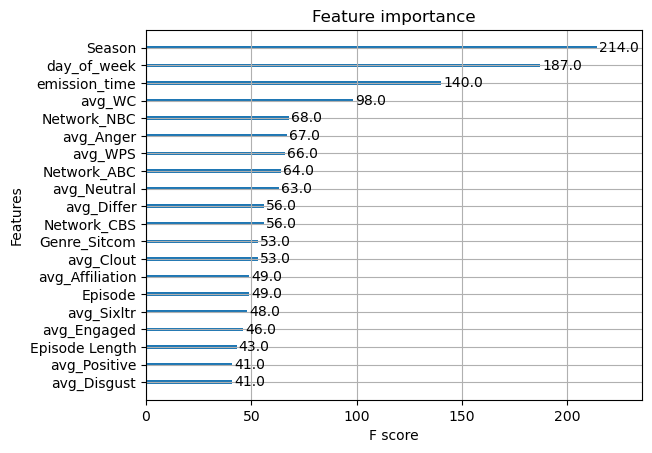

In [131]:
import matplotlib.pyplot as plt
import xgboost.plotting as xgb_plot

# Get feature importance
xgb.plot_importance(xgb_regressor, importance_type="weight", max_num_features=20)
plt.show()

# Research Question: Does sentiment variability between episodes impact audience retention?

In [249]:
new_data.sort_values(by='vw_pct_change', ascending = False).head(10)

,Show,Season,Episode,emission_time,Episode Length,IMDB Rating,Emmy Nominations,Emmy Wins,Air Date,SD_div_mean_2,...,avg_Time,month,year,year_month,day_of_week,season,year_season,vw_diff,vw_pct_change,moving_avg_vw
17966,Rick and Morty,3,2,11:00 PM,22,NaN,NaN,NaN,2017-07-30,16709.403380,...,3.329167,7,2017,2017-07,Sunday,3,2017_03,2.180,320.588235,1.770000
1536,Barry,2,3,10:00 PM,33,NaN,NaN,NaN,2019-04-14,4545.223415,...,2.801333,4,2019,2019-04,Sunday,2,2019_02,1.356,319.811321,0.912000
1783,Better Things,4,3,10:00 PM,22,NaN,NaN,NaN,2020-03-12,6480.745403,...,3.778704,3,2020,2020-03,Thursday,2,2020_02,0.333,204.294479,0.320333
519,3rd Rock from the Sun,3,14,9:00 PM,22,NaN,NaN,NaN,1998-01-25,3784.822150,...,3.999048,1,1998,1998-01,Sunday,1,1998_01,22.450,200.267618,19.073333
9483,Girls,3,6,10:00 PM,28,NaN,NaN,NaN,2014-02-09,8763.509573,...,3.676889,2,2014,2014-02,Sunday,1,2014_01,0.555,199.640288,0.588667
23816,This Is Us,2,14,9:00 PM,42,NaN,NaN,NaN,2018-02-04,4486.167636,...,4.476556,2,2018,2018-02,Sunday,1,2018_01,17.600,187.833511,15.386667
9688,Gravity Falls,2,6,9:00 PM,22,NaN,NaN,NaN,2014-10-04,8776.750441,...,4.010774,10,2014,2014-10,Saturday,4,2014_04,1.470,175.000000,1.340000
20669,The Blacklist,2,9,10:00 PM,42,NaN,NaN,NaN,2015-02-01,6190.057446,...,3.650571,2,2015,2015-02,Sunday,1,2015_01,15.970,163.794872,14.923333
22544,The Office,5,14,9:00 PM,22,NaN,NaN,NaN,2009-02-01,4288.434384,...,3.229940,2,2009,2009-02,Sunday,1,2009_01,14.150,161.529680,13.386667
13818,Mad About You,7,19,8:00 PM,22,NaN,NaN,NaN,1999-05-13,3442.047487,...,4.202857,5,1999,1999-05,Thursday,2,1999_02,11.890,158.533333,11.933333


# XGBoost Model

In [301]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [308]:
new_data = new_data[new_data['Genre'] == 'Sitcom']

In [310]:
# Drop first episodes since they have no prior reference
new_data = new_data.dropna(subset=["vw_pct_change"])
model_data = new_data[[
 'Episode Length',
 'Viewership (millions)',
 'Year',
 'Cancelled',
 'avg_SD_div_mean',
 'avg_SD_sum',
 'avg_SD_scaled',
 'avg_Anger',
 'avg_Surprise',
 'avg_Disgust',
 'avg_Sadness',
 'avg_Neutral',
 'avg_Fear',
 'avg_Joy',
 'avg_Positive',
 'avg_Negative',
 'avg_Engaged',
 'avg_Not engaged',
 'avg_WC',
 'avg_Analytic',
 'avg_Clout',
 'avg_Authentic',
 'avg_Tone',
 'avg_WPS',
 'avg_Sixltr',
 'avg_Dic',
 'avg_Cogproc',
 'avg_Insight',
 'avg_Cause',
 'avg_Discrep',
 'avg_Tentat',
 'avg_Certain',
 'avg_Differ',
 'avg_Percept',
 'avg_See',
 'avg_Hear',
 'avg_Feel',
 'avg_Drives',
 'avg_Affiliation',
 'avg_Achieve',
 'avg_Power',
 'avg_Reward',
 'avg_Risk',
 'avg_Relativ',
 'avg_Motion',
 'avg_Space',
 'avg_Time',
 'month',
 'year',
 'season',
 'vw_diff',
 'vw_pct_change',
 'moving_avg_vw']]

In [312]:
# Define features (X) and target variable (y)
X = model_data.drop(columns=['vw_diff','vw_pct_change', 'Viewership (millions)'])  # Features
y = model_data['vw_pct_change']  # Target variable

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [314]:
# Convert data into DMatrix format (XGBoost requirement)
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    "objective": "reg:squarederror",  # Regression problem
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 5,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "n_estimators": 100
}

# Train model
xgb_regressor = xgb.train(params, train_data, num_boost_round=100)

C:\Users\mermo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


## Model Performance

In [317]:
# Make predictions
y_pred = xgb_regressor.predict(test_data)

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 14.2357
R² Score: -0.0512


## Feature Importance

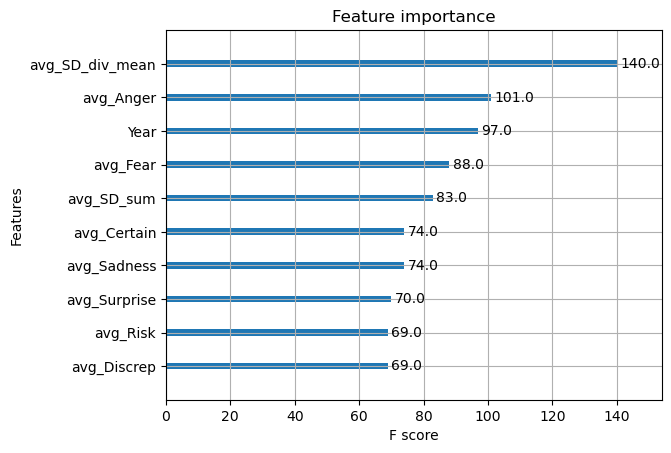

In [320]:
import matplotlib.pyplot as plt
import xgboost.plotting as xgb_plot

# Get feature importance
xgb.plot_importance(xgb_regressor, importance_type="weight", max_num_features=10)
plt.show()